<a href="https://colab.research.google.com/github/srinivasanibmbangalore/OpenCVDeepLearningCertification/blob/master/OpencvAssignment_SkinSmoothing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import argparse
import dlib
import os
import shutil
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm

In [5]:
matplotlib.rcParams['figure.figsize'] = (8.0,8.0)
matplotlib.rcParams['image.cmap'] = 'gray'

In [6]:
from google.colab import drive

drive.mount('/content/gdrive')
root_image_path = '/content/gdrive/My Drive/ml_data/OpenCVCertification/images'

imgPath=root_image_path+"/hillary_clinton.jpg"

Mounted at /content/gdrive


In [8]:
img = cv2.imread(imgPath,1)
if (img.any() == None):
  print("Empty Image")

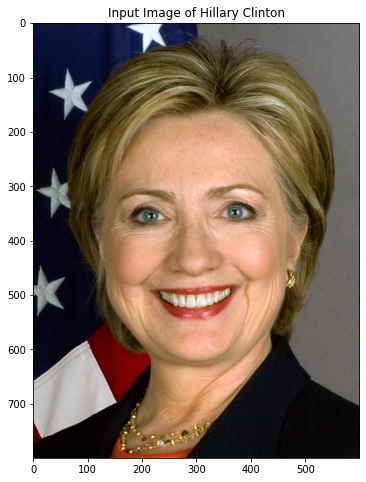

In [9]:
plt.imshow(img[:,:,::-1])
plt.title("Input Image of Hillary Clinton")
plt.show()

In [24]:
detector = dlib.get_frontal_face_detector()
imgGray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
faces = detector(imgGray)

for face in faces:
    print(face.left)
    x1,y1 = face.left(),face.top()
    x2,y2 = face.right(),face.bottom()
    imgFaceBound=cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),2)
print(len(faces))
print("X1:",x1," Y1:",y1," X2:",x2," Y2:",y2)


<bound method PyCapsule.left of rectangle(115,238,486,610)>
1
X1: 115  Y1: 238  X2: 486  Y2: 610


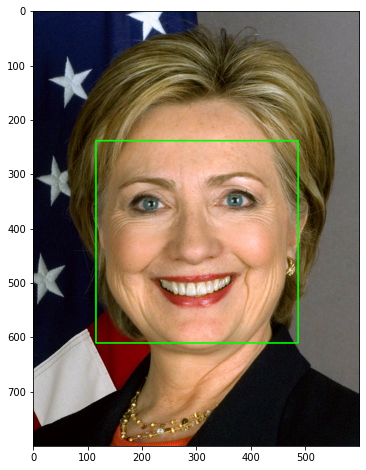

In [22]:
plt.imshow(imgFaceBound[:,:,::-1])

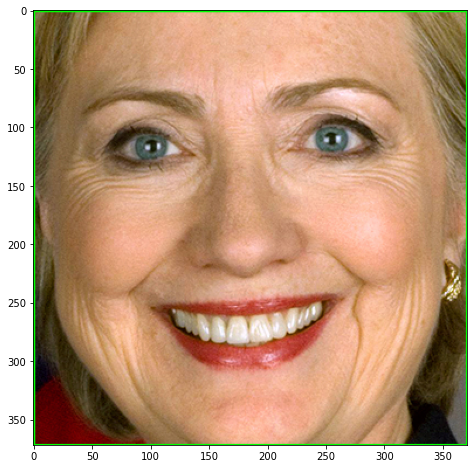

In [25]:
imgF=img[y1:y2,x1:x2]
plt.imshow(imgF[:,:,::-1])

In [26]:
def getYcrCBSkinMask(image):
    min_YCrCb = np.array([0,133,77],np.uint8)
    max_YCrCb = np.array([235,173,127],np.uint8)

    # Get pointer to video frames from primary device
    #image = cv2.imread("/assets/img/skin-detection/rock.jpg")
    imageYCrCb = cv2.cvtColor(image,cv2.COLOR_BGR2YCR_CB)
    skinRegionYCrCb = cv2.inRange(imageYCrCb,min_YCrCb,max_YCrCb)

    skinYCrCb = cv2.bitwise_and(image, image, mask = skinRegionYCrCb)

    #cv2.imwrite("/assets/img/skin-detection/ycrcb.png", np.hstack([image,skinYCrCb]))
    return skinYCrCb

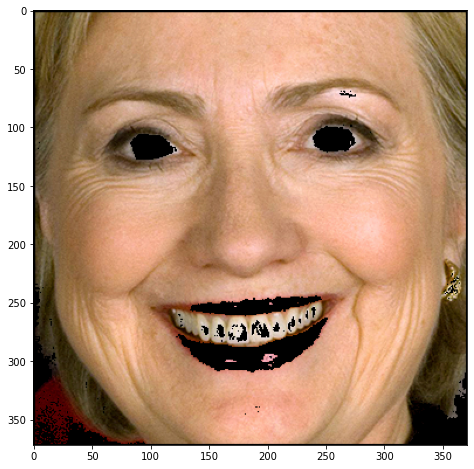

In [27]:
mask_YCrCb=getYcrCBSkinMask(imgF)
plt.imshow(mask_YCrCb[:,:,::-1])

In [32]:
def getHSVSkinMask(image):
    min_HSV = np.array([0, 58, 30], dtype = "uint8")
    max_HSV = np.array([33, 255, 255], dtype = "uint8")
    # Get pointer to video frames from primary device
    #image = cv2.imread("/assets/img/skin-detection/rock.jpg")
    imageHSV = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    skinRegionHSV = cv2.inRange(imageHSV, min_HSV, max_HSV)

    skinHSV = cv2.bitwise_and(image, image, mask = skinRegionHSV)
    return skinHSV
    

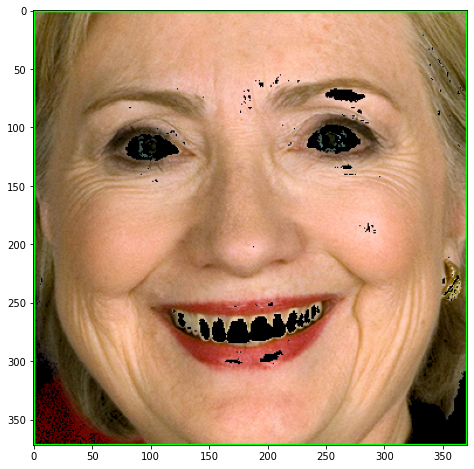

In [33]:
mask_hsv=getHSVSkinMask(imgF)
plt.imshow(mask_hsv[:,:,::-1])

In [52]:
def getHSVYRCB(img):
    img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    #skin color range for hsv color space 
    HSV_mask = cv2.inRange(img_HSV, (0, 15, 0), (17,170,255)) 
    HSV_mask = cv2.morphologyEx(HSV_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

    #converting from gbr to YCbCr color space
    img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    #skin color range for hsv color space 
    YCrCb_mask = cv2.inRange(img_YCrCb, (0, 135, 85), (255,180,135)) 
    YCrCb_mask = cv2.morphologyEx(YCrCb_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

    #merge skin detection (YCbCr and hsv)
    global_mask=cv2.bitwise_and(YCrCb_mask,HSV_mask)
    global_mask=cv2.medianBlur(global_mask,3)
    global_mask = cv2.morphologyEx(global_mask, cv2.MORPH_OPEN, np.ones((4,4), np.uint8))

    HSV_result = cv2.bitwise_not(HSV_mask)
    YCrCb_result = cv2.bitwise_not(YCrCb_mask)
    global_result=cv2.bitwise_not(global_mask)

    return global_mask

In [54]:
imgF.shape

(372, 371, 3)

(372, 371)

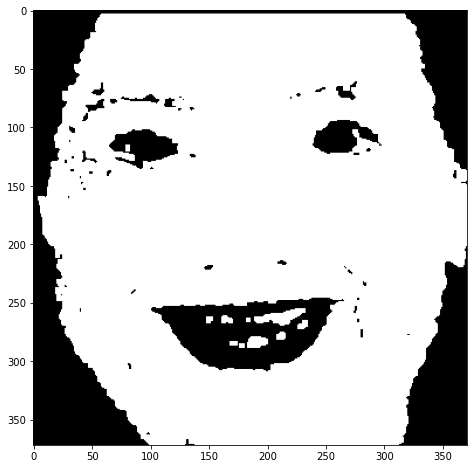

In [55]:
gMask = getHSVYRCB(imgF)
plt.imshow(gMask)
gMask.shape

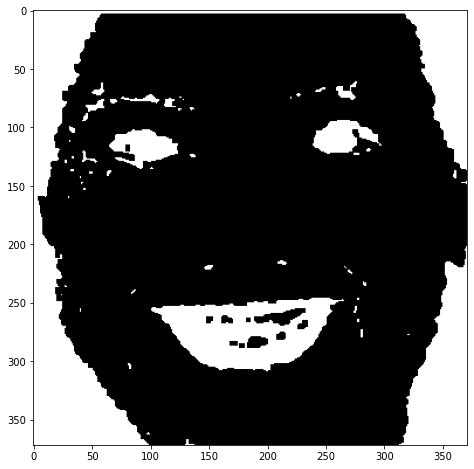

In [108]:
mask_inv = cv2.bitwise_not(gMask)
plt.imshow(mask_inv)

Text(0.5, 1.0, 'Eroded Image')

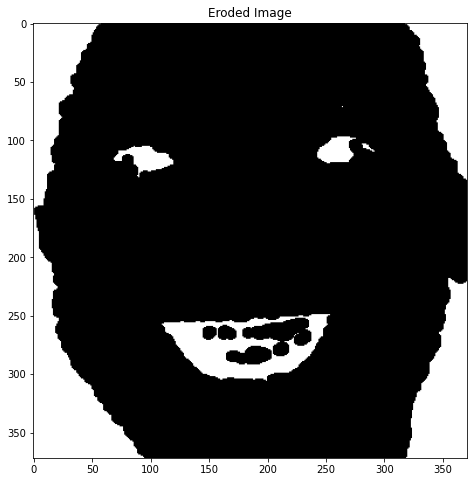

In [125]:
kernelSize = 3

# Create Kernel
element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*kernelSize+1, 2*kernelSize+1),
                                    (kernelSize, kernelSize))
imEroded2 = cv2.erode(mask_inv, element)
# Perform Erosion
plt.imshow(imEroded2)
plt.title("Eroded Image")

(372, 371)

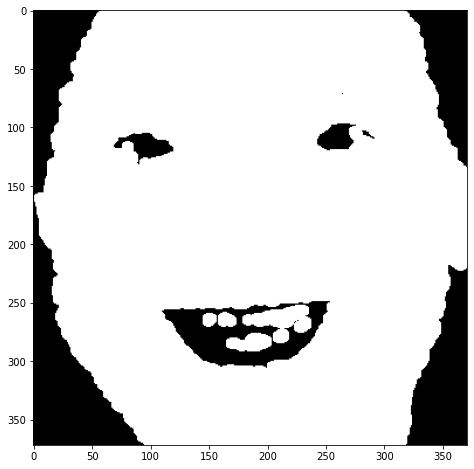

In [126]:
gMask=cv2.bitwise_not(imEroded2)
plt.imshow(gMask)
gMask.shape

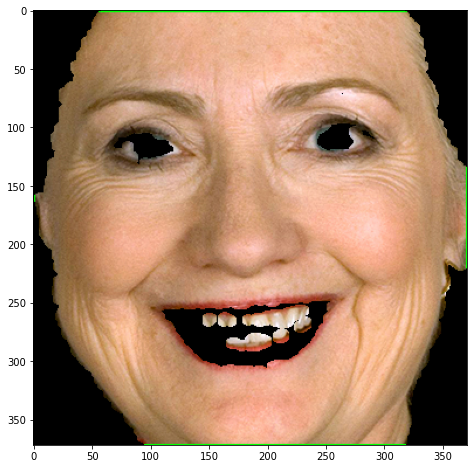

In [127]:
'''
imgFGr = cv2.cvtColor(imgF,cv2.COLOR_BGR2GRAY)
nImg = cv2.bitwise_and(imgFGr,gMask)
nImg1=cv2.cvtColor(nImg,cv2.COLOR_GRAY2BGR)
#plt.imshow(nImg)
plt.imshow(nImg1[:,:,::-1])
'''
skin = cv2.bitwise_and(imgF, imgF, mask = gMask)
plt.imshow(skin[:,:,::-1])

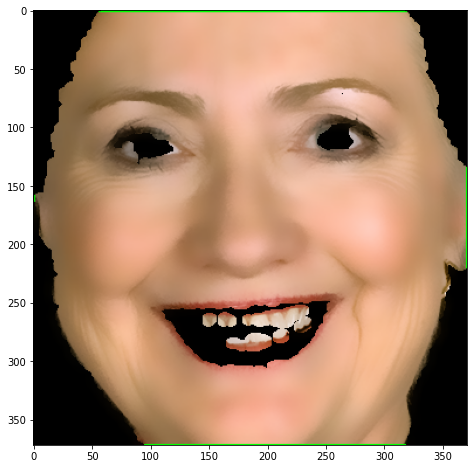

In [128]:
blur = cv2.bilateralFilter(skin,18,85,85)
plt.imshow(blur[:,:,::-1])

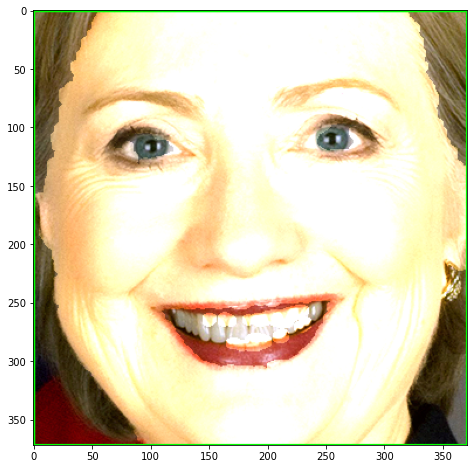

In [129]:

hImage = cv2.addWeighted(imgF,1,blur,0.8,0)
plt.imshow(hImage[:,:,::-1])


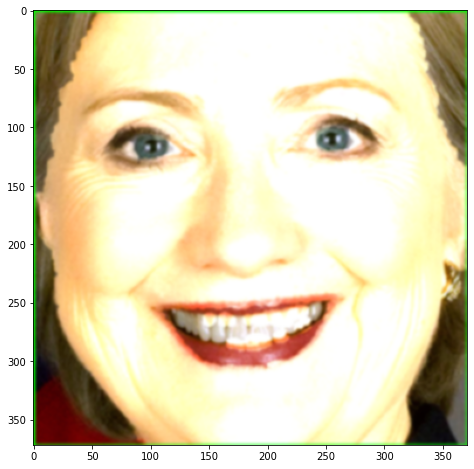

In [130]:
hImage = cv2.GaussianBlur(hImage,(5,5),0)
plt.imshow(hImage[:,:,::-1])